# Image Captioning with LSTMs
In the previous exercise you implemented a vanilla RNN and applied it to image captioning. In this notebook you will implement the LSTM update rule and use it for image captioning.

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

/home/m/opt/anaconda3/envs/cs231n-a3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load MS-COCO data
As in the previous notebook, we will use the Microsoft COCO dataset for captioning.

In [2]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


# LSTM
If you read recent papers, you'll see that many people use a variant on the vanialla RNN called Long-Short Term Memory (LSTM) RNNs. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradiants caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task. 

In the code, we assume that data is stored in batches so that $X_t \in \mathbb{R}^{N\times D}$, and will work with *transposed* versions of the parameters: $W_x \in \mathbb{R}^{D \times 4H}$, $W_h \in \mathbb{R}^{H\times 4H}$ so that activations $A \in \mathbb{R}^{N\times 4H}$ can be computed efficiently as $A = X_t W_x + H_{t-1} W_h$

# LSTM: step forward
Implement the forward pass for a single timestep of an LSTM in the `lstm_step_forward` function in the file `cs231n/rnn_layers.py`. This should be similar to the `rnn_step_forward` function that you implemented above, but using the LSTM update rule instead.

Once you are done, run the following to perform a simple test of your implementation. You should see errors around `1e-8` or less.

In [3]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  5.7054131967097955e-09
next_c error:  5.8143123088804145e-09


# LSTM: step backward
Implement the backward pass for a single LSTM timestep in the function `lstm_step_backward` in the file `cs231n/rnn_layers.py`. Once you are done, run the following to perform numeric gradient checking on your implementation. You should see errors around `1e-6` or less.

In [4]:
np.random.seed(231)

N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dh error: ', rel_error(dh_num, dh))
print('dc error: ', rel_error(dc_num, dc))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  6.335032254429549e-10
dh error:  3.3963774090592634e-10
dc error:  1.5221723979041107e-10
dWx error:  2.1010960934639614e-09
dWh error:  9.712296109943072e-08
db error:  2.491522041931035e-10


# LSTM: forward
In the function `lstm_forward` in the file `cs231n/rnn_layers.py`, implement the `lstm_forward` function to run an LSTM forward on an entire timeseries of data.

When you are done, run the following to check your implementation. You should see an error around `1e-7`.

In [5]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, b)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print('h error: ', rel_error(expected_h, h))

h error:  8.610537452106624e-08


# LSTM: backward
Implement the backward pass for an LSTM over an entire timeseries of data in the function `lstm_backward` in the file `cs231n/rnn_layers.py`. When you are done, run the following to perform numeric gradient checking on your implementation. You should see errors around `1e-7` or less.

In [6]:
from cs231n.rnn_layers import lstm_forward, lstm_backward
np.random.seed(231)

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)

fx = lambda x: lstm_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: lstm_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: lstm_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: lstm_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: lstm_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  7.838503094280515e-09
dh0 error:  2.469092580080717e-08
dWx error:  4.748336603829709e-09
dWh error:  1.0424408314821048e-06
db error:  1.9152724138992987e-09


# LSTM captioning model

Now that you have implemented an LSTM, update the implementation of the `loss` method of the `CaptioningRNN` class in the file `cs231n/classifiers/rnn.py` to handle the case where `self.cell_type` is `lstm`. This should require adding less than 10 lines of code.

Once you have done so, run the following to check your implementation. You should see a difference of less than `1e-10`.

In [7]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='lstm',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
  model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.82445935443226
expected loss:  9.82445935443
difference:  2.261302256556519e-12


# Overfit LSTM captioning model
Run the following to overfit an LSTM captioning model on the same small dataset as we used for the RNN previously. You should see losses less than 0.5.

/home/m/workspace/ml/stanford-cs231n/assignment3/cs231n/optim.py:77: RuntimeWarning: invalid value encountered in sqrt
  x -= alpha * (m / (np.sqrt(v) + eps))


(Iteration 1 / 100) loss: 79.551150
(Iteration 11 / 100) loss: 43.829101
(Iteration 21 / 100) loss: 30.062628
(Iteration 31 / 100) loss: 14.020096
(Iteration 41 / 100) loss: 6.003686
(Iteration 51 / 100) loss: 1.850801
(Iteration 61 / 100) loss: 0.639320
(Iteration 71 / 100) loss: 0.284141
(Iteration 81 / 100) loss: 0.236418
(Iteration 91 / 100) loss: 0.124555


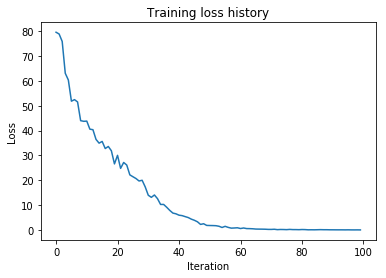

In [8]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# LSTM test-time sampling
Modify the `sample` method of the `CaptioningRNN` class to handle the case where `self.cell_type` is `lstm`. This should take fewer than 10 lines of code.

When you are done run the following to sample from your overfit LSTM model on some training and validation set samples.

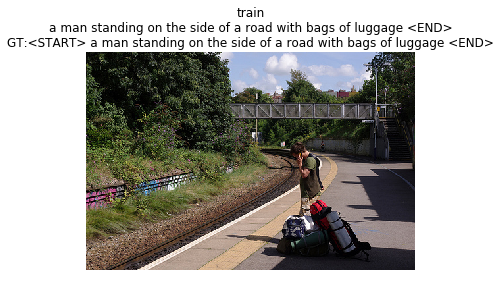

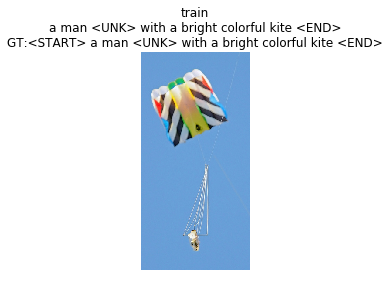

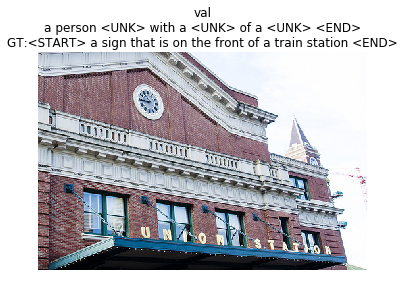

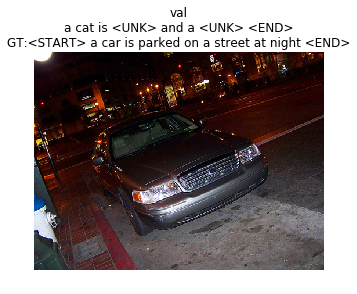

In [9]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

# Extra Credit: Train a good captioning model!
Using the pieces you have implemented in this and the previous notebook, try to train a captioning model that gives decent qualitative results (better than the random garbage you saw with the overfit models) when sampling on the validation set. You can subsample the training set if you want; we just want to see samples on the validation set that are better than random.

In addition to qualitatively evaluating your model by inspecting its results, you can also quantitatively evaluate your model using the BLEU unigram precision metric. We'll give you a small amount of extra credit if you can train a model that achieves a BLEU unigram score of >0.3. BLEU scores range from 0 to 1; the closer to 1, the better. Here's a reference to the [paper](http://www.aclweb.org/anthology/P02-1040.pdf) that introduces BLEU if you're interested in learning more about how it works.

Feel free to use PyTorch or TensorFlow for this section if you'd like to train faster on a GPU... though you can definitely get above 0.3 using your Numpy code. We're providing you the evaluation code that is compatible with the Numpy model as defined above... you should be able to adapt it for TensorFlow/PyTorch if you go that route.

In [11]:
import nltk

def BLEU_score(gt_caption, sample_caption):
    """
    gt_caption: string, ground-truth caption
    sample_caption: string, your model's predicted caption
    Returns unigram BLEU score.
    """
    reference = [x for x in gt_caption.split(' ') 
                 if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    hypothesis = [x for x in sample_caption.split(' ') 
                  if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights = [1])
    return BLEUscore

def evaluate_model(model, data):
    """
    model: CaptioningRNN model
    Prints unigram BLEU score averaged over 1000 training and val examples.
    """
    BLEUscores = {}
    for split in ['train', 'val']:
        minibatch = sample_coco_minibatch(data, split=split, batch_size=1000)
        gt_captions, features, urls = minibatch
        gt_captions = decode_captions(gt_captions, data['idx_to_word'])

        sample_captions = model.sample(features)
        sample_captions = decode_captions(sample_captions, data['idx_to_word'])

        total_score = 0.0
        for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
            total_score += BLEU_score(gt_caption, sample_caption)

        BLEUscores[split] = total_score / len(sample_captions)

    for split in BLEUscores:
        print('Average BLEU score for %s: %f' % (split, BLEUscores[split]))

/home/m/workspace/ml/stanford-cs231n/assignment3/cs231n/optim.py:77: RuntimeWarning: invalid value encountered in sqrt
  x -= alpha * (m / (np.sqrt(v) + eps))


(Iteration 1 / 20000) loss: 74.454662
(Iteration 101 / 20000) loss: 52.790253
(Iteration 201 / 20000) loss: 44.111659
(Iteration 301 / 20000) loss: 40.816599
(Iteration 401 / 20000) loss: 37.036611
(Iteration 501 / 20000) loss: 34.364434
(Iteration 601 / 20000) loss: 33.520185
(Iteration 701 / 20000) loss: 33.621845
(Iteration 801 / 20000) loss: 32.339577
(Iteration 901 / 20000) loss: 33.500815
(Iteration 1001 / 20000) loss: 33.614353
(Iteration 1101 / 20000) loss: 29.351754
(Iteration 1201 / 20000) loss: 28.010666
(Iteration 1301 / 20000) loss: 27.379684
(Iteration 1401 / 20000) loss: 28.327527
(Iteration 1501 / 20000) loss: 29.502013
(Iteration 1601 / 20000) loss: 26.688067
(Iteration 1701 / 20000) loss: 23.774637
(Iteration 1801 / 20000) loss: 27.379774
(Iteration 1901 / 20000) loss: 26.726164
(Iteration 2001 / 20000) loss: 23.049767
(Iteration 2101 / 20000) loss: 22.337035
(Iteration 2201 / 20000) loss: 20.472716
(Iteration 2301 / 20000) loss: 22.117404
(Iteration 2401 / 20000) los

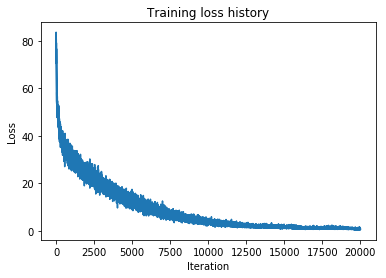

10000 512 0.0005 0.995
Average BLEU score for train: 0.951338
Average BLEU score for val: 0.260171
(Iteration 1 / 20000) loss: 77.113499
(Iteration 101 / 20000) loss: 47.361303
(Iteration 201 / 20000) loss: 41.867005
(Iteration 301 / 20000) loss: 38.366504
(Iteration 401 / 20000) loss: 42.233988
(Iteration 501 / 20000) loss: 38.073157
(Iteration 601 / 20000) loss: 32.154858
(Iteration 701 / 20000) loss: 36.238760
(Iteration 801 / 20000) loss: 30.081938
(Iteration 901 / 20000) loss: 29.405172
(Iteration 1001 / 20000) loss: 31.307360
(Iteration 1101 / 20000) loss: 29.339849
(Iteration 1201 / 20000) loss: 28.538336
(Iteration 1301 / 20000) loss: 33.857142
(Iteration 1401 / 20000) loss: 27.698056
(Iteration 1501 / 20000) loss: 26.000177
(Iteration 1601 / 20000) loss: 25.868335
(Iteration 1701 / 20000) loss: 27.694460
(Iteration 1801 / 20000) loss: 21.821744
(Iteration 1901 / 20000) loss: 24.762742
(Iteration 2001 / 20000) loss: 21.496570
(Iteration 2101 / 20000) loss: 22.124540
(Iteration 

(Iteration 19901 / 20000) loss: 0.676699


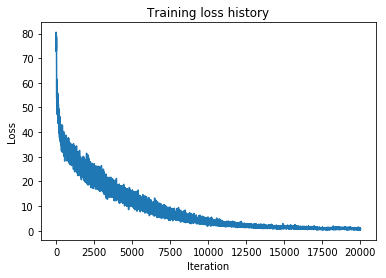

10000 512 0.0005 0.99
Average BLEU score for train: 0.953371
Average BLEU score for val: 0.250998
(Iteration 1 / 20000) loss: 76.534654
(Iteration 101 / 20000) loss: 50.357052
(Iteration 201 / 20000) loss: 44.991534
(Iteration 301 / 20000) loss: 37.072979
(Iteration 401 / 20000) loss: 35.500871
(Iteration 501 / 20000) loss: 38.744212
(Iteration 601 / 20000) loss: 32.953744
(Iteration 701 / 20000) loss: 34.273493
(Iteration 801 / 20000) loss: 29.493010
(Iteration 901 / 20000) loss: 32.626764
(Iteration 1001 / 20000) loss: 30.289978
(Iteration 1101 / 20000) loss: 28.347538
(Iteration 1201 / 20000) loss: 30.260841
(Iteration 1301 / 20000) loss: 26.242614
(Iteration 1401 / 20000) loss: 27.419223
(Iteration 1501 / 20000) loss: 27.527992
(Iteration 1601 / 20000) loss: 24.356460
(Iteration 1701 / 20000) loss: 26.150754
(Iteration 1801 / 20000) loss: 26.663542
(Iteration 1901 / 20000) loss: 23.610395
(Iteration 2001 / 20000) loss: 24.045616
(Iteration 2101 / 20000) loss: 21.225295
(Iteration 2

(Iteration 19901 / 20000) loss: 1.096288


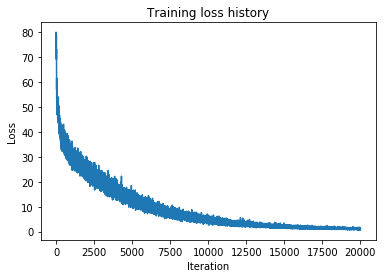

10000 512 0.0005 0.95
Average BLEU score for train: 0.963011
Average BLEU score for val: 0.252033
(Iteration 1 / 20000) loss: 83.641893
(Iteration 101 / 20000) loss: 43.979099
(Iteration 201 / 20000) loss: 36.667477
(Iteration 301 / 20000) loss: 34.827426
(Iteration 401 / 20000) loss: 34.370998
(Iteration 501 / 20000) loss: 29.340523
(Iteration 601 / 20000) loss: 27.309370
(Iteration 701 / 20000) loss: 31.832290
(Iteration 801 / 20000) loss: 26.745142
(Iteration 901 / 20000) loss: 28.864308
(Iteration 1001 / 20000) loss: 26.799454
(Iteration 1101 / 20000) loss: 27.154518
(Iteration 1201 / 20000) loss: 27.922041
(Iteration 1301 / 20000) loss: 22.116272
(Iteration 1401 / 20000) loss: 26.971075
(Iteration 1501 / 20000) loss: 22.276687
(Iteration 1601 / 20000) loss: 20.609659
(Iteration 1701 / 20000) loss: 23.675416
(Iteration 1801 / 20000) loss: 22.371488
(Iteration 1901 / 20000) loss: 21.214840
(Iteration 2001 / 20000) loss: 22.794404
(Iteration 2101 / 20000) loss: 19.444129
(Iteration 2

(Iteration 19901 / 20000) loss: 1.831856


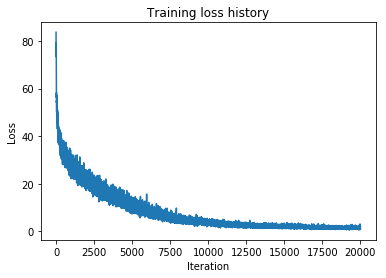

10000 512 0.001 0.995
Average BLEU score for train: 0.854297
Average BLEU score for val: 0.241742
(Iteration 1 / 20000) loss: 75.130467
(Iteration 101 / 20000) loss: 46.548301
(Iteration 201 / 20000) loss: 40.960261
(Iteration 301 / 20000) loss: 34.290031
(Iteration 401 / 20000) loss: 35.419608
(Iteration 501 / 20000) loss: 32.247514
(Iteration 601 / 20000) loss: 35.328329
(Iteration 701 / 20000) loss: 29.598945
(Iteration 801 / 20000) loss: 28.473031
(Iteration 901 / 20000) loss: 30.536224
(Iteration 1001 / 20000) loss: 25.571416
(Iteration 1101 / 20000) loss: 25.633910
(Iteration 1201 / 20000) loss: 26.903627
(Iteration 1301 / 20000) loss: 23.916135
(Iteration 1401 / 20000) loss: 23.727930
(Iteration 1501 / 20000) loss: 24.694722
(Iteration 1601 / 20000) loss: 24.174738
(Iteration 1701 / 20000) loss: 26.174045
(Iteration 1801 / 20000) loss: 26.364664
(Iteration 1901 / 20000) loss: 25.323691
(Iteration 2001 / 20000) loss: 19.849091
(Iteration 2101 / 20000) loss: 24.052532
(Iteration 2

(Iteration 19901 / 20000) loss: 0.628112


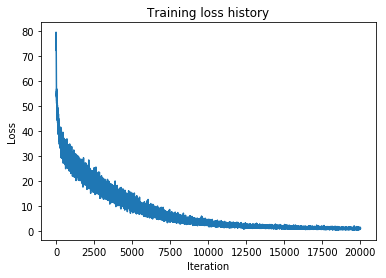

10000 512 0.001 0.99
Average BLEU score for train: 0.913636
Average BLEU score for val: 0.246758
(Iteration 1 / 20000) loss: 75.358548
(Iteration 101 / 20000) loss: 43.598852
(Iteration 201 / 20000) loss: 42.200197
(Iteration 301 / 20000) loss: 38.900300
(Iteration 401 / 20000) loss: 36.335041
(Iteration 501 / 20000) loss: 33.637945
(Iteration 601 / 20000) loss: 33.597963
(Iteration 701 / 20000) loss: 35.065052
(Iteration 801 / 20000) loss: 28.470855
(Iteration 901 / 20000) loss: 30.489410
(Iteration 1001 / 20000) loss: 24.915329
(Iteration 1101 / 20000) loss: 26.751091
(Iteration 1201 / 20000) loss: 25.395497
(Iteration 1301 / 20000) loss: 23.797005
(Iteration 1401 / 20000) loss: 25.368780
(Iteration 1501 / 20000) loss: 25.408303
(Iteration 1601 / 20000) loss: 23.196423
(Iteration 1701 / 20000) loss: 21.596330
(Iteration 1801 / 20000) loss: 23.984429
(Iteration 1901 / 20000) loss: 21.268478
(Iteration 2001 / 20000) loss: 22.575165
(Iteration 2101 / 20000) loss: 25.953089
(Iteration 22

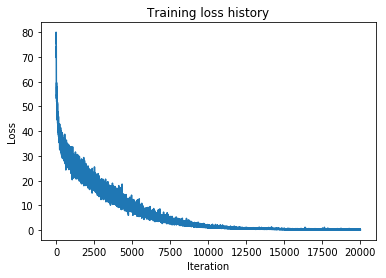

10000 512 0.001 0.95
Average BLEU score for train: 0.960300
Average BLEU score for val: 0.259682
(Iteration 1 / 20000) loss: 75.918327
(Iteration 101 / 20000) loss: 39.274612
(Iteration 201 / 20000) loss: 36.000876
(Iteration 301 / 20000) loss: 32.761630
(Iteration 401 / 20000) loss: 29.466680
(Iteration 501 / 20000) loss: 28.368931
(Iteration 601 / 20000) loss: 30.098178
(Iteration 701 / 20000) loss: 28.451036
(Iteration 801 / 20000) loss: 24.593865
(Iteration 901 / 20000) loss: 28.320479
(Iteration 1001 / 20000) loss: 24.263240
(Iteration 1101 / 20000) loss: 25.484593
(Iteration 1201 / 20000) loss: 24.190966
(Iteration 1301 / 20000) loss: 26.186389
(Iteration 1401 / 20000) loss: 21.927393
(Iteration 1501 / 20000) loss: 23.841720
(Iteration 1601 / 20000) loss: 25.812274
(Iteration 1701 / 20000) loss: 25.227988
(Iteration 1801 / 20000) loss: 22.356241
(Iteration 1901 / 20000) loss: 21.610055
(Iteration 2001 / 20000) loss: 23.125726
(Iteration 2101 / 20000) loss: 24.458458
(Iteration 22

(Iteration 19601 / 20000) loss: 10.180869
(Iteration 19701 / 20000) loss: 14.263864
(Iteration 19801 / 20000) loss: 10.663932
(Iteration 19901 / 20000) loss: 12.572016


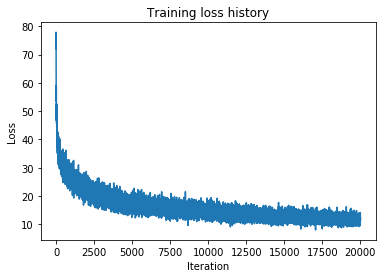

10000 512 0.005 0.995
Average BLEU score for train: 0.251195
Average BLEU score for val: 0.213409
(Iteration 1 / 20000) loss: 77.749698
(Iteration 101 / 20000) loss: 38.482103
(Iteration 201 / 20000) loss: 36.675703
(Iteration 301 / 20000) loss: 32.158999
(Iteration 401 / 20000) loss: 29.658784
(Iteration 501 / 20000) loss: 27.900287
(Iteration 601 / 20000) loss: 27.636689
(Iteration 701 / 20000) loss: 26.000050
(Iteration 801 / 20000) loss: 28.588035
(Iteration 901 / 20000) loss: 26.686717
(Iteration 1001 / 20000) loss: 21.185749
(Iteration 1101 / 20000) loss: 25.578255
(Iteration 1201 / 20000) loss: 23.636818
(Iteration 1301 / 20000) loss: 26.123749
(Iteration 1401 / 20000) loss: 26.565969
(Iteration 1501 / 20000) loss: 24.714269
(Iteration 1601 / 20000) loss: 24.796223
(Iteration 1701 / 20000) loss: 22.461708
(Iteration 1801 / 20000) loss: 21.310152
(Iteration 1901 / 20000) loss: 27.634155
(Iteration 2001 / 20000) loss: 22.321973
(Iteration 2101 / 20000) loss: 21.939270
(Iteration 2

(Iteration 19601 / 20000) loss: 9.822279
(Iteration 19701 / 20000) loss: 9.918603
(Iteration 19801 / 20000) loss: 10.205542
(Iteration 19901 / 20000) loss: 8.357375


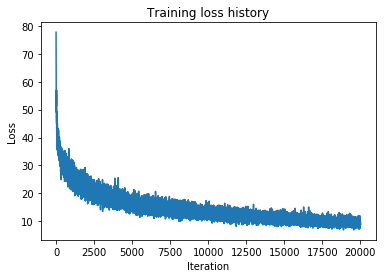

10000 512 0.005 0.99
Average BLEU score for train: 0.266906
Average BLEU score for val: 0.217366
(Iteration 1 / 20000) loss: 74.101809
(Iteration 101 / 20000) loss: 41.978782
(Iteration 201 / 20000) loss: 34.337089
(Iteration 301 / 20000) loss: 29.891094
(Iteration 401 / 20000) loss: 32.247052
(Iteration 501 / 20000) loss: 30.235829
(Iteration 601 / 20000) loss: 30.198160
(Iteration 701 / 20000) loss: 25.147246
(Iteration 801 / 20000) loss: 26.011325
(Iteration 901 / 20000) loss: 23.249683
(Iteration 1001 / 20000) loss: 26.038702
(Iteration 1101 / 20000) loss: 21.409434
(Iteration 1201 / 20000) loss: 28.039304
(Iteration 1301 / 20000) loss: 27.045237
(Iteration 1401 / 20000) loss: 25.251539
(Iteration 1501 / 20000) loss: 23.563766
(Iteration 1601 / 20000) loss: 23.447018
(Iteration 1701 / 20000) loss: 18.502578
(Iteration 1801 / 20000) loss: 26.780827
(Iteration 1901 / 20000) loss: 20.394525
(Iteration 2001 / 20000) loss: 18.920999
(Iteration 2101 / 20000) loss: 21.186369
(Iteration 22

(Iteration 19901 / 20000) loss: 1.746345


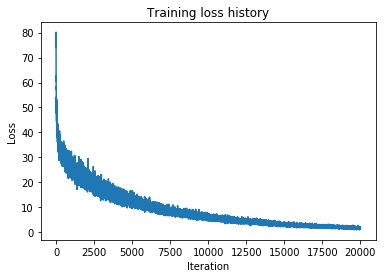

10000 512 0.005 0.95
Average BLEU score for train: 0.739318
Average BLEU score for val: 0.225452
(Iteration 1 / 20000) loss: 75.586433
(Iteration 101 / 20000) loss: 52.245873
(Iteration 201 / 20000) loss: 38.564521
(Iteration 301 / 20000) loss: 37.489878
(Iteration 401 / 20000) loss: 34.131442
(Iteration 501 / 20000) loss: 33.656339
(Iteration 601 / 20000) loss: 32.291431
(Iteration 701 / 20000) loss: 32.892840
(Iteration 801 / 20000) loss: 32.697928
(Iteration 901 / 20000) loss: 30.381915
(Iteration 1001 / 20000) loss: 27.517674
(Iteration 1101 / 20000) loss: 25.102352
(Iteration 1201 / 20000) loss: 26.553622
(Iteration 1301 / 20000) loss: 23.769653
(Iteration 1401 / 20000) loss: 26.996938
(Iteration 1501 / 20000) loss: 24.659060
(Iteration 1601 / 20000) loss: 21.898154
(Iteration 1701 / 20000) loss: 22.902661
(Iteration 1801 / 20000) loss: 24.603313
(Iteration 1901 / 20000) loss: 22.249540
(Iteration 2001 / 20000) loss: 20.770246
(Iteration 2101 / 20000) loss: 20.080367
(Iteration 22

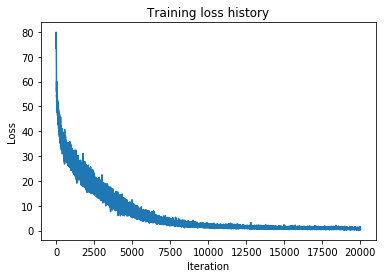

10000 768 0.0005 0.995
Average BLEU score for train: 0.945404
Average BLEU score for val: 0.258411
(Iteration 1 / 20000) loss: 73.597721
(Iteration 101 / 20000) loss: 46.435705
(Iteration 201 / 20000) loss: 42.362275
(Iteration 301 / 20000) loss: 35.549638
(Iteration 401 / 20000) loss: 37.112855
(Iteration 501 / 20000) loss: 37.535679
(Iteration 601 / 20000) loss: 34.089106
(Iteration 701 / 20000) loss: 33.711260
(Iteration 801 / 20000) loss: 29.447668
(Iteration 901 / 20000) loss: 34.038912
(Iteration 1001 / 20000) loss: 28.716211
(Iteration 1101 / 20000) loss: 27.670794
(Iteration 1201 / 20000) loss: 24.588402
(Iteration 1301 / 20000) loss: 24.776182
(Iteration 1401 / 20000) loss: 20.767809
(Iteration 1501 / 20000) loss: 22.202113
(Iteration 1601 / 20000) loss: 24.557113
(Iteration 1701 / 20000) loss: 21.485082
(Iteration 1801 / 20000) loss: 22.966241
(Iteration 1901 / 20000) loss: 22.384474
(Iteration 2001 / 20000) loss: 19.352040
(Iteration 2101 / 20000) loss: 20.711270
(Iteration 

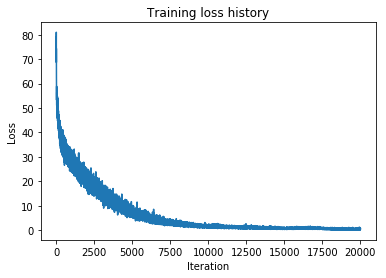

10000 768 0.0005 0.99
Average BLEU score for train: 0.965277
Average BLEU score for val: 0.267035
(Iteration 1 / 20000) loss: 81.645205
(Iteration 101 / 20000) loss: 55.462370
(Iteration 201 / 20000) loss: 43.013735
(Iteration 301 / 20000) loss: 36.465722
(Iteration 401 / 20000) loss: 33.622661
(Iteration 501 / 20000) loss: 34.462157
(Iteration 601 / 20000) loss: 32.507006
(Iteration 701 / 20000) loss: 33.463938
(Iteration 801 / 20000) loss: 34.197537
(Iteration 901 / 20000) loss: 30.900106
(Iteration 1001 / 20000) loss: 27.714458
(Iteration 1101 / 20000) loss: 26.541418
(Iteration 1201 / 20000) loss: 29.524831
(Iteration 1301 / 20000) loss: 22.176661
(Iteration 1401 / 20000) loss: 23.155484
(Iteration 1501 / 20000) loss: 23.472590
(Iteration 1601 / 20000) loss: 24.467095
(Iteration 1701 / 20000) loss: 21.799954
(Iteration 1801 / 20000) loss: 21.435567
(Iteration 1901 / 20000) loss: 19.889516
(Iteration 2001 / 20000) loss: 22.949305
(Iteration 2101 / 20000) loss: 18.910239
(Iteration 2

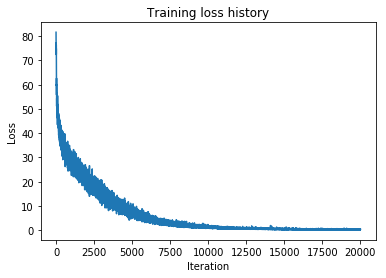

10000 768 0.0005 0.95
Average BLEU score for train: 0.968822
Average BLEU score for val: 0.270905
(Iteration 1 / 20000) loss: 81.651391
(Iteration 101 / 20000) loss: 45.438130
(Iteration 201 / 20000) loss: 39.790067
(Iteration 301 / 20000) loss: 38.034174
(Iteration 401 / 20000) loss: 32.279950
(Iteration 501 / 20000) loss: 30.735109
(Iteration 601 / 20000) loss: 28.275483
(Iteration 701 / 20000) loss: 29.584749
(Iteration 801 / 20000) loss: 27.122579
(Iteration 901 / 20000) loss: 26.884119
(Iteration 1001 / 20000) loss: 23.730518
(Iteration 1101 / 20000) loss: 26.303091
(Iteration 1201 / 20000) loss: 25.156539
(Iteration 1301 / 20000) loss: 26.829106
(Iteration 1401 / 20000) loss: 20.958827
(Iteration 1501 / 20000) loss: 22.191264
(Iteration 1601 / 20000) loss: 21.474473
(Iteration 1701 / 20000) loss: 18.564782
(Iteration 1801 / 20000) loss: 23.575951
(Iteration 1901 / 20000) loss: 23.735970
(Iteration 2001 / 20000) loss: 16.879576
(Iteration 2101 / 20000) loss: 18.180057
(Iteration 2

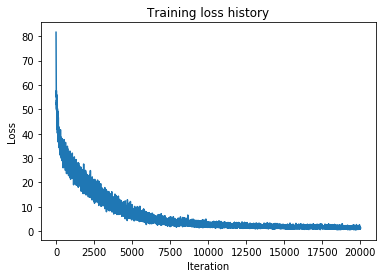

10000 768 0.001 0.995
Average BLEU score for train: 0.830025
Average BLEU score for val: 0.247519
(Iteration 1 / 20000) loss: 74.087348
(Iteration 101 / 20000) loss: 43.009109
(Iteration 201 / 20000) loss: 40.884600
(Iteration 301 / 20000) loss: 31.880520
(Iteration 401 / 20000) loss: 31.981463
(Iteration 501 / 20000) loss: 31.449359
(Iteration 601 / 20000) loss: 32.566525
(Iteration 701 / 20000) loss: 30.197883
(Iteration 801 / 20000) loss: 29.084619
(Iteration 901 / 20000) loss: 24.198262
(Iteration 1001 / 20000) loss: 25.032496
(Iteration 1101 / 20000) loss: 21.452063
(Iteration 1201 / 20000) loss: 22.587604
(Iteration 1301 / 20000) loss: 24.447182
(Iteration 1401 / 20000) loss: 21.528601
(Iteration 1501 / 20000) loss: 20.296954
(Iteration 1601 / 20000) loss: 23.994555
(Iteration 1701 / 20000) loss: 21.586791
(Iteration 1801 / 20000) loss: 20.477082
(Iteration 1901 / 20000) loss: 19.727099
(Iteration 2001 / 20000) loss: 19.448300
(Iteration 2101 / 20000) loss: 20.397436
(Iteration 2

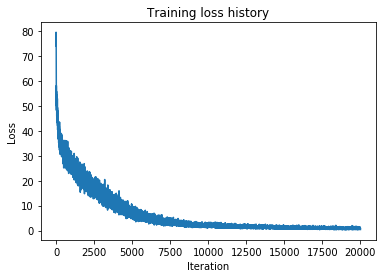

10000 768 0.001 0.99
Average BLEU score for train: 0.926342
Average BLEU score for val: 0.240057
(Iteration 1 / 20000) loss: 75.335365
(Iteration 101 / 20000) loss: 44.737240
(Iteration 201 / 20000) loss: 38.755891
(Iteration 301 / 20000) loss: 32.640856
(Iteration 401 / 20000) loss: 30.909530
(Iteration 501 / 20000) loss: 31.927558
(Iteration 601 / 20000) loss: 32.272666
(Iteration 701 / 20000) loss: 28.644277
(Iteration 801 / 20000) loss: 28.310969
(Iteration 901 / 20000) loss: 25.702474
(Iteration 1001 / 20000) loss: 27.294806
(Iteration 1101 / 20000) loss: 23.391791
(Iteration 1201 / 20000) loss: 24.027087
(Iteration 1301 / 20000) loss: 25.787683
(Iteration 1401 / 20000) loss: 19.782482
(Iteration 1501 / 20000) loss: 25.808964
(Iteration 1601 / 20000) loss: 20.469827
(Iteration 1701 / 20000) loss: 22.000865
(Iteration 1801 / 20000) loss: 20.609439
(Iteration 1901 / 20000) loss: 18.436622
(Iteration 2001 / 20000) loss: 19.299027
(Iteration 2101 / 20000) loss: 17.827700
(Iteration 22

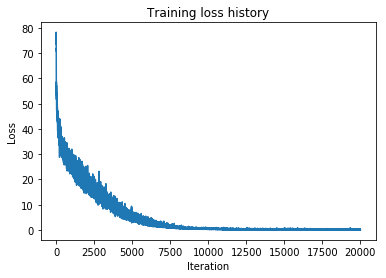

10000 768 0.001 0.95
Average BLEU score for train: 0.971931
Average BLEU score for val: 0.272051
(Iteration 1 / 20000) loss: 72.190343
(Iteration 101 / 20000) loss: 37.709321
(Iteration 201 / 20000) loss: 31.886504
(Iteration 301 / 20000) loss: 32.155403
(Iteration 401 / 20000) loss: 28.222499
(Iteration 501 / 20000) loss: 31.734152
(Iteration 601 / 20000) loss: 30.187818
(Iteration 701 / 20000) loss: 30.824803
(Iteration 801 / 20000) loss: 31.213031
(Iteration 901 / 20000) loss: 23.154814
(Iteration 1001 / 20000) loss: 26.547419
(Iteration 1101 / 20000) loss: 26.286896
(Iteration 1201 / 20000) loss: 23.489931
(Iteration 1301 / 20000) loss: 26.411809
(Iteration 1401 / 20000) loss: 21.216739
(Iteration 1501 / 20000) loss: 21.951263
(Iteration 1601 / 20000) loss: 22.417075
(Iteration 1701 / 20000) loss: 27.110903
(Iteration 1801 / 20000) loss: 22.149680
(Iteration 1901 / 20000) loss: 23.663333
(Iteration 2001 / 20000) loss: 19.757114
(Iteration 2101 / 20000) loss: 17.786403
(Iteration 22

(Iteration 19601 / 20000) loss: 11.249541
(Iteration 19701 / 20000) loss: 15.106820
(Iteration 19801 / 20000) loss: 12.551482
(Iteration 19901 / 20000) loss: 11.035911


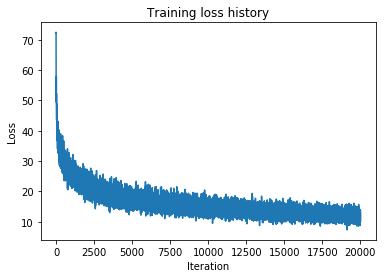

10000 768 0.005 0.995
Average BLEU score for train: 0.268678
Average BLEU score for val: 0.208436
(Iteration 1 / 20000) loss: 77.421637
(Iteration 101 / 20000) loss: 38.525891
(Iteration 201 / 20000) loss: 31.343303
(Iteration 301 / 20000) loss: 31.268795
(Iteration 401 / 20000) loss: 31.999556
(Iteration 501 / 20000) loss: 29.508126
(Iteration 601 / 20000) loss: 33.696928
(Iteration 701 / 20000) loss: 25.880907
(Iteration 801 / 20000) loss: 25.576617
(Iteration 901 / 20000) loss: 30.011819
(Iteration 1001 / 20000) loss: 22.484821
(Iteration 1101 / 20000) loss: 24.438433
(Iteration 1201 / 20000) loss: 25.563602
(Iteration 1301 / 20000) loss: 23.031755
(Iteration 1401 / 20000) loss: 24.721366
(Iteration 1501 / 20000) loss: 27.888211
(Iteration 1601 / 20000) loss: 24.160144
(Iteration 1701 / 20000) loss: 24.965177
(Iteration 1801 / 20000) loss: 21.793117
(Iteration 1901 / 20000) loss: 20.189705
(Iteration 2001 / 20000) loss: 21.768573
(Iteration 2101 / 20000) loss: 22.493650
(Iteration 2

(Iteration 19701 / 20000) loss: 7.676274
(Iteration 19801 / 20000) loss: 10.152936
(Iteration 19901 / 20000) loss: 9.294019


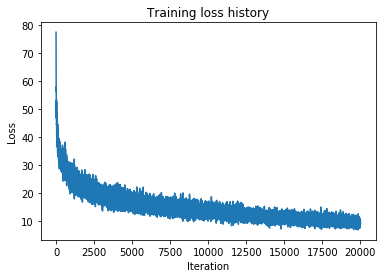

10000 768 0.005 0.99
Average BLEU score for train: 0.273952
Average BLEU score for val: 0.208196
(Iteration 1 / 20000) loss: 75.691548
(Iteration 101 / 20000) loss: 40.356031
(Iteration 201 / 20000) loss: 33.889678
(Iteration 301 / 20000) loss: 33.745304
(Iteration 401 / 20000) loss: 31.017911
(Iteration 501 / 20000) loss: 29.988203
(Iteration 601 / 20000) loss: 34.067838
(Iteration 701 / 20000) loss: 26.675187
(Iteration 801 / 20000) loss: 20.703589
(Iteration 901 / 20000) loss: 30.325749
(Iteration 1001 / 20000) loss: 25.958815
(Iteration 1101 / 20000) loss: 24.244778
(Iteration 1201 / 20000) loss: 22.639784
(Iteration 1301 / 20000) loss: 25.552804
(Iteration 1401 / 20000) loss: 24.684500
(Iteration 1501 / 20000) loss: 23.068964
(Iteration 1601 / 20000) loss: 16.566602
(Iteration 1701 / 20000) loss: 19.908273
(Iteration 1801 / 20000) loss: 22.127437
(Iteration 1901 / 20000) loss: 15.622021
(Iteration 2001 / 20000) loss: 20.705755
(Iteration 2101 / 20000) loss: 17.319534
(Iteration 22

(Iteration 19901 / 20000) loss: 1.509989


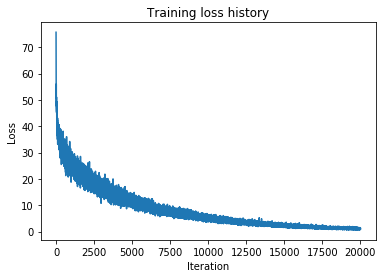

10000 768 0.005 0.95
Average BLEU score for train: 0.826219
Average BLEU score for val: 0.217640
(Iteration 1 / 30000) loss: 77.740207
(Iteration 101 / 30000) loss: 51.581491
(Iteration 201 / 30000) loss: 41.379469
(Iteration 301 / 30000) loss: 39.647756
(Iteration 401 / 30000) loss: 39.307896
(Iteration 501 / 30000) loss: 37.163082
(Iteration 601 / 30000) loss: 37.141067
(Iteration 701 / 30000) loss: 31.976398
(Iteration 801 / 30000) loss: 30.761701
(Iteration 901 / 30000) loss: 31.646378
(Iteration 1001 / 30000) loss: 32.962688
(Iteration 1101 / 30000) loss: 31.530832
(Iteration 1201 / 30000) loss: 31.222436
(Iteration 1301 / 30000) loss: 28.325497
(Iteration 1401 / 30000) loss: 30.967642
(Iteration 1501 / 30000) loss: 29.188139
(Iteration 1601 / 30000) loss: 28.461472
(Iteration 1701 / 30000) loss: 28.148429
(Iteration 1801 / 30000) loss: 27.509287
(Iteration 1901 / 30000) loss: 24.534535
(Iteration 2001 / 30000) loss: 25.399862
(Iteration 2101 / 30000) loss: 28.613024
(Iteration 22

(Iteration 19801 / 30000) loss: 2.223887
(Iteration 19901 / 30000) loss: 2.161521
(Iteration 20001 / 30000) loss: 2.600270
(Iteration 20101 / 30000) loss: 2.800761
(Iteration 20201 / 30000) loss: 2.817430
(Iteration 20301 / 30000) loss: 1.844995
(Iteration 20401 / 30000) loss: 2.556651
(Iteration 20501 / 30000) loss: 2.511450
(Iteration 20601 / 30000) loss: 2.564682
(Iteration 20701 / 30000) loss: 2.904774
(Iteration 20801 / 30000) loss: 2.312209
(Iteration 20901 / 30000) loss: 2.508109
(Iteration 21001 / 30000) loss: 2.310284
(Iteration 21101 / 30000) loss: 2.274571
(Iteration 21201 / 30000) loss: 2.001967
(Iteration 21301 / 30000) loss: 2.728424
(Iteration 21401 / 30000) loss: 3.693075
(Iteration 21501 / 30000) loss: 1.721976
(Iteration 21601 / 30000) loss: 2.529288
(Iteration 21701 / 30000) loss: 2.217155
(Iteration 21801 / 30000) loss: 2.218593
(Iteration 21901 / 30000) loss: 3.296206
(Iteration 22001 / 30000) loss: 2.583458
(Iteration 22101 / 30000) loss: 2.171281
(Iteration 22201

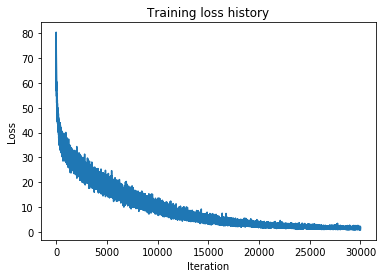

15000 512 0.0005 0.995
Average BLEU score for train: 0.893177
Average BLEU score for val: 0.246256
(Iteration 1 / 30000) loss: 77.480562
(Iteration 101 / 30000) loss: 52.702292
(Iteration 201 / 30000) loss: 42.730665
(Iteration 301 / 30000) loss: 41.109136
(Iteration 401 / 30000) loss: 36.117439
(Iteration 501 / 30000) loss: 36.983632
(Iteration 601 / 30000) loss: 34.283798
(Iteration 701 / 30000) loss: 33.538472
(Iteration 801 / 30000) loss: 30.814287
(Iteration 901 / 30000) loss: 30.279753
(Iteration 1001 / 30000) loss: 33.221059
(Iteration 1101 / 30000) loss: 31.674805
(Iteration 1201 / 30000) loss: 32.880634
(Iteration 1301 / 30000) loss: 27.859106
(Iteration 1401 / 30000) loss: 29.269578
(Iteration 1501 / 30000) loss: 31.752254
(Iteration 1601 / 30000) loss: 28.221100
(Iteration 1701 / 30000) loss: 31.712990
(Iteration 1801 / 30000) loss: 28.377242
(Iteration 1901 / 30000) loss: 30.378381
(Iteration 2001 / 30000) loss: 27.907304
(Iteration 2101 / 30000) loss: 24.733284
(Iteration 

(Iteration 19801 / 30000) loss: 2.479353
(Iteration 19901 / 30000) loss: 3.701168
(Iteration 20001 / 30000) loss: 2.633889
(Iteration 20101 / 30000) loss: 1.727931
(Iteration 20201 / 30000) loss: 2.940578
(Iteration 20301 / 30000) loss: 1.686804
(Iteration 20401 / 30000) loss: 2.542455
(Iteration 20501 / 30000) loss: 2.517031
(Iteration 20601 / 30000) loss: 2.027948
(Iteration 20701 / 30000) loss: 1.964643
(Iteration 20801 / 30000) loss: 2.626812
(Iteration 20901 / 30000) loss: 1.680338
(Iteration 21001 / 30000) loss: 2.005889
(Iteration 21101 / 30000) loss: 2.578180
(Iteration 21201 / 30000) loss: 2.498085
(Iteration 21301 / 30000) loss: 1.989339
(Iteration 21401 / 30000) loss: 2.135379
(Iteration 21501 / 30000) loss: 2.116230
(Iteration 21601 / 30000) loss: 1.718360
(Iteration 21701 / 30000) loss: 1.546132
(Iteration 21801 / 30000) loss: 1.388021
(Iteration 21901 / 30000) loss: 1.757481
(Iteration 22001 / 30000) loss: 1.330765
(Iteration 22101 / 30000) loss: 2.303140
(Iteration 22201

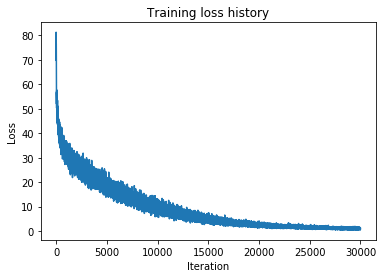

15000 512 0.0005 0.99
Average BLEU score for train: 0.935123
Average BLEU score for val: 0.257035
(Iteration 1 / 30000) loss: 74.381122
(Iteration 101 / 30000) loss: 51.959285
(Iteration 201 / 30000) loss: 43.953027
(Iteration 301 / 30000) loss: 41.971477
(Iteration 401 / 30000) loss: 38.535963
(Iteration 501 / 30000) loss: 38.549164
(Iteration 601 / 30000) loss: 35.558350
(Iteration 701 / 30000) loss: 31.470686
(Iteration 801 / 30000) loss: 30.995871
(Iteration 901 / 30000) loss: 32.276810
(Iteration 1001 / 30000) loss: 30.957218
(Iteration 1101 / 30000) loss: 33.454811
(Iteration 1201 / 30000) loss: 31.616341
(Iteration 1301 / 30000) loss: 30.290007
(Iteration 1401 / 30000) loss: 32.579063
(Iteration 1501 / 30000) loss: 28.053078
(Iteration 1601 / 30000) loss: 27.807787
(Iteration 1701 / 30000) loss: 27.902399
(Iteration 1801 / 30000) loss: 28.290512
(Iteration 1901 / 30000) loss: 23.695416
(Iteration 2001 / 30000) loss: 25.136109
(Iteration 2101 / 30000) loss: 27.865870
(Iteration 2

(Iteration 19801 / 30000) loss: 2.767901
(Iteration 19901 / 30000) loss: 2.632459
(Iteration 20001 / 30000) loss: 3.370808
(Iteration 20101 / 30000) loss: 2.392630
(Iteration 20201 / 30000) loss: 3.196931
(Iteration 20301 / 30000) loss: 2.017978
(Iteration 20401 / 30000) loss: 3.008043
(Iteration 20501 / 30000) loss: 2.767492
(Iteration 20601 / 30000) loss: 2.331180
(Iteration 20701 / 30000) loss: 3.239428
(Iteration 20801 / 30000) loss: 2.743663
(Iteration 20901 / 30000) loss: 2.516323
(Iteration 21001 / 30000) loss: 2.883863
(Iteration 21101 / 30000) loss: 2.350021
(Iteration 21201 / 30000) loss: 3.319246
(Iteration 21301 / 30000) loss: 2.339485
(Iteration 21401 / 30000) loss: 2.673939
(Iteration 21501 / 30000) loss: 2.676060
(Iteration 21601 / 30000) loss: 2.973190
(Iteration 21701 / 30000) loss: 2.566457
(Iteration 21801 / 30000) loss: 2.116105
(Iteration 21901 / 30000) loss: 3.123739
(Iteration 22001 / 30000) loss: 2.964108
(Iteration 22101 / 30000) loss: 2.959814
(Iteration 22201

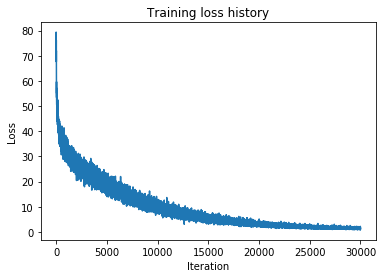

15000 512 0.0005 0.95
Average BLEU score for train: 0.933690
Average BLEU score for val: 0.260438
(Iteration 1 / 30000) loss: 79.415220
(Iteration 101 / 30000) loss: 44.473125
(Iteration 201 / 30000) loss: 42.552037
(Iteration 301 / 30000) loss: 33.664453
(Iteration 401 / 30000) loss: 32.860885
(Iteration 501 / 30000) loss: 31.425995
(Iteration 601 / 30000) loss: 32.906592
(Iteration 701 / 30000) loss: 32.700958
(Iteration 801 / 30000) loss: 29.428952
(Iteration 901 / 30000) loss: 32.304902
(Iteration 1001 / 30000) loss: 30.441259
(Iteration 1101 / 30000) loss: 30.944506
(Iteration 1201 / 30000) loss: 28.842642
(Iteration 1301 / 30000) loss: 28.032921
(Iteration 1401 / 30000) loss: 27.991876
(Iteration 1501 / 30000) loss: 28.895488
(Iteration 1601 / 30000) loss: 28.972618
(Iteration 1701 / 30000) loss: 27.381038
(Iteration 1801 / 30000) loss: 23.523233
(Iteration 1901 / 30000) loss: 23.517998
(Iteration 2001 / 30000) loss: 24.179171
(Iteration 2101 / 30000) loss: 25.970605
(Iteration 2

(Iteration 19801 / 30000) loss: 4.538308
(Iteration 19901 / 30000) loss: 3.488528
(Iteration 20001 / 30000) loss: 4.641333
(Iteration 20101 / 30000) loss: 3.628407
(Iteration 20201 / 30000) loss: 4.924008
(Iteration 20301 / 30000) loss: 4.082807
(Iteration 20401 / 30000) loss: 3.226140
(Iteration 20501 / 30000) loss: 4.153553
(Iteration 20601 / 30000) loss: 3.899598
(Iteration 20701 / 30000) loss: 4.473699
(Iteration 20801 / 30000) loss: 5.813139
(Iteration 20901 / 30000) loss: 3.595101
(Iteration 21001 / 30000) loss: 4.717015
(Iteration 21101 / 30000) loss: 3.803274
(Iteration 21201 / 30000) loss: 3.860461
(Iteration 21301 / 30000) loss: 4.071779
(Iteration 21401 / 30000) loss: 3.924696
(Iteration 21501 / 30000) loss: 3.339527
(Iteration 21601 / 30000) loss: 4.313093
(Iteration 21701 / 30000) loss: 3.629581
(Iteration 21801 / 30000) loss: 3.570075
(Iteration 21901 / 30000) loss: 3.789742
(Iteration 22001 / 30000) loss: 4.113885
(Iteration 22101 / 30000) loss: 3.766851
(Iteration 22201

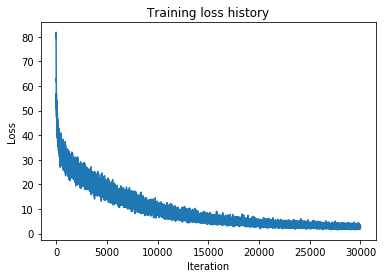

15000 512 0.001 0.995
Average BLEU score for train: 0.717533
Average BLEU score for val: 0.235949
(Iteration 1 / 30000) loss: 76.884196
(Iteration 101 / 30000) loss: 47.769776
(Iteration 201 / 30000) loss: 37.189295
(Iteration 301 / 30000) loss: 35.551574
(Iteration 401 / 30000) loss: 38.975577
(Iteration 501 / 30000) loss: 34.513033
(Iteration 601 / 30000) loss: 33.167271
(Iteration 701 / 30000) loss: 31.798791
(Iteration 801 / 30000) loss: 26.235007
(Iteration 901 / 30000) loss: 30.903654
(Iteration 1001 / 30000) loss: 29.487284
(Iteration 1101 / 30000) loss: 28.027674
(Iteration 1201 / 30000) loss: 26.816844
(Iteration 1301 / 30000) loss: 29.465410
(Iteration 1401 / 30000) loss: 28.089432
(Iteration 1501 / 30000) loss: 25.407407
(Iteration 1601 / 30000) loss: 24.671784
(Iteration 1701 / 30000) loss: 25.192760
(Iteration 1801 / 30000) loss: 22.129410
(Iteration 1901 / 30000) loss: 24.574001
(Iteration 2001 / 30000) loss: 23.725640
(Iteration 2101 / 30000) loss: 23.627816
(Iteration 2

(Iteration 19801 / 30000) loss: 3.210568
(Iteration 19901 / 30000) loss: 4.311881
(Iteration 20001 / 30000) loss: 2.637730
(Iteration 20101 / 30000) loss: 2.477420
(Iteration 20201 / 30000) loss: 2.095304
(Iteration 20301 / 30000) loss: 2.753573
(Iteration 20401 / 30000) loss: 3.244073
(Iteration 20501 / 30000) loss: 2.605723
(Iteration 20601 / 30000) loss: 2.690921
(Iteration 20701 / 30000) loss: 3.164092
(Iteration 20801 / 30000) loss: 2.276547
(Iteration 20901 / 30000) loss: 2.414902
(Iteration 21001 / 30000) loss: 1.930883
(Iteration 21101 / 30000) loss: 3.099174
(Iteration 21201 / 30000) loss: 2.649360
(Iteration 21301 / 30000) loss: 2.206958
(Iteration 21401 / 30000) loss: 1.717233
(Iteration 21501 / 30000) loss: 2.852091
(Iteration 21601 / 30000) loss: 2.588350
(Iteration 21701 / 30000) loss: 2.332679
(Iteration 21801 / 30000) loss: 2.988208
(Iteration 21901 / 30000) loss: 2.595517
(Iteration 22001 / 30000) loss: 2.700935
(Iteration 22101 / 30000) loss: 1.893760
(Iteration 22201

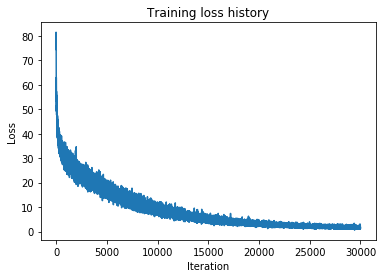

15000 512 0.001 0.99
Average BLEU score for train: 0.835932
Average BLEU score for val: 0.245401
(Iteration 1 / 30000) loss: 77.809656
(Iteration 101 / 30000) loss: 43.126372
(Iteration 201 / 30000) loss: 40.006987
(Iteration 301 / 30000) loss: 35.296053
(Iteration 401 / 30000) loss: 34.454772
(Iteration 501 / 30000) loss: 33.320143
(Iteration 601 / 30000) loss: 34.375895
(Iteration 701 / 30000) loss: 31.117852
(Iteration 801 / 30000) loss: 29.388501
(Iteration 901 / 30000) loss: 30.512957
(Iteration 1001 / 30000) loss: 31.585419
(Iteration 1101 / 30000) loss: 28.287184
(Iteration 1201 / 30000) loss: 27.932539
(Iteration 1301 / 30000) loss: 24.633995
(Iteration 1401 / 30000) loss: 29.161534
(Iteration 1501 / 30000) loss: 25.525194
(Iteration 1601 / 30000) loss: 26.068023
(Iteration 1701 / 30000) loss: 30.732046
(Iteration 1801 / 30000) loss: 26.482377
(Iteration 1901 / 30000) loss: 23.427446
(Iteration 2001 / 30000) loss: 24.504173
(Iteration 2101 / 30000) loss: 29.320665
(Iteration 22

(Iteration 19901 / 30000) loss: 1.010026
(Iteration 20001 / 30000) loss: 0.790828
(Iteration 20101 / 30000) loss: 0.613838
(Iteration 20201 / 30000) loss: 1.035027
(Iteration 20301 / 30000) loss: 0.838683
(Iteration 20401 / 30000) loss: 0.644036
(Iteration 20501 / 30000) loss: 0.991402
(Iteration 20601 / 30000) loss: 0.738634
(Iteration 20701 / 30000) loss: 1.064121
(Iteration 20801 / 30000) loss: 0.653538
(Iteration 20901 / 30000) loss: 0.590543
(Iteration 21001 / 30000) loss: 0.685709
(Iteration 21101 / 30000) loss: 1.112201
(Iteration 21201 / 30000) loss: 0.948506
(Iteration 21301 / 30000) loss: 0.788203
(Iteration 21401 / 30000) loss: 0.445445
(Iteration 21501 / 30000) loss: 0.898515
(Iteration 21601 / 30000) loss: 0.844047
(Iteration 21701 / 30000) loss: 0.636239
(Iteration 21801 / 30000) loss: 0.774572
(Iteration 21901 / 30000) loss: 0.672142
(Iteration 22001 / 30000) loss: 0.594715
(Iteration 22101 / 30000) loss: 0.570655
(Iteration 22201 / 30000) loss: 0.686126
(Iteration 22301

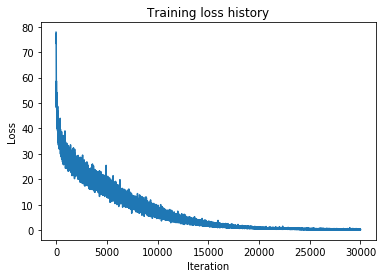

15000 512 0.001 0.95
Average BLEU score for train: 0.958662
Average BLEU score for val: 0.264528
(Iteration 1 / 30000) loss: 73.574946
(Iteration 101 / 30000) loss: 39.200703
(Iteration 201 / 30000) loss: 38.318394
(Iteration 301 / 30000) loss: 39.557018
(Iteration 401 / 30000) loss: 30.722190
(Iteration 501 / 30000) loss: 29.566457
(Iteration 601 / 30000) loss: 30.265734
(Iteration 701 / 30000) loss: 27.010686
(Iteration 801 / 30000) loss: 26.814736
(Iteration 901 / 30000) loss: 29.062807
(Iteration 1001 / 30000) loss: 27.867438
(Iteration 1101 / 30000) loss: 27.656465
(Iteration 1201 / 30000) loss: 24.940526
(Iteration 1301 / 30000) loss: 26.844224
(Iteration 1401 / 30000) loss: 28.208455
(Iteration 1501 / 30000) loss: 27.023091
(Iteration 1601 / 30000) loss: 24.531681
(Iteration 1701 / 30000) loss: 26.026370
(Iteration 1801 / 30000) loss: 23.969958
(Iteration 1901 / 30000) loss: 25.721990
(Iteration 2001 / 30000) loss: 24.637281
(Iteration 2101 / 30000) loss: 24.480109
(Iteration 22

(Iteration 19601 / 30000) loss: 15.960866
(Iteration 19701 / 30000) loss: 15.731805
(Iteration 19801 / 30000) loss: 15.231283
(Iteration 19901 / 30000) loss: 14.643004
(Iteration 20001 / 30000) loss: 15.066639
(Iteration 20101 / 30000) loss: 15.958989
(Iteration 20201 / 30000) loss: 17.859229
(Iteration 20301 / 30000) loss: 11.682735
(Iteration 20401 / 30000) loss: 15.819971
(Iteration 20501 / 30000) loss: 17.066299
(Iteration 20601 / 30000) loss: 15.968721
(Iteration 20701 / 30000) loss: 15.763279
(Iteration 20801 / 30000) loss: 15.735481
(Iteration 20901 / 30000) loss: 18.284856
(Iteration 21001 / 30000) loss: 15.439391
(Iteration 21101 / 30000) loss: 15.940112
(Iteration 21201 / 30000) loss: 14.491683
(Iteration 21301 / 30000) loss: 18.023596
(Iteration 21401 / 30000) loss: 16.172861
(Iteration 21501 / 30000) loss: 14.912528
(Iteration 21601 / 30000) loss: 16.696896
(Iteration 21701 / 30000) loss: 14.645920
(Iteration 21801 / 30000) loss: 14.332745
(Iteration 21901 / 30000) loss: 14

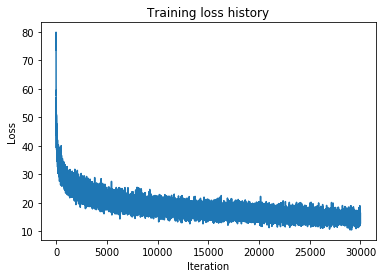

15000 512 0.005 0.995
Average BLEU score for train: 0.234382
Average BLEU score for val: 0.225520
(Iteration 1 / 30000) loss: 75.783988
(Iteration 101 / 30000) loss: 38.192807
(Iteration 201 / 30000) loss: 32.910144
(Iteration 301 / 30000) loss: 30.590456
(Iteration 401 / 30000) loss: 35.080390
(Iteration 501 / 30000) loss: 32.550933
(Iteration 601 / 30000) loss: 26.289425
(Iteration 701 / 30000) loss: 24.577892
(Iteration 801 / 30000) loss: 30.489454
(Iteration 901 / 30000) loss: 31.742472
(Iteration 1001 / 30000) loss: 22.407091
(Iteration 1101 / 30000) loss: 26.444644
(Iteration 1201 / 30000) loss: 27.780223
(Iteration 1301 / 30000) loss: 24.293609
(Iteration 1401 / 30000) loss: 25.647841
(Iteration 1501 / 30000) loss: 27.881774
(Iteration 1601 / 30000) loss: 24.102627
(Iteration 1701 / 30000) loss: 25.641245
(Iteration 1801 / 30000) loss: 25.307363
(Iteration 1901 / 30000) loss: 24.555505
(Iteration 2001 / 30000) loss: 25.895668
(Iteration 2101 / 30000) loss: 28.539486
(Iteration 2

(Iteration 19601 / 30000) loss: 13.984264
(Iteration 19701 / 30000) loss: 15.074121
(Iteration 19801 / 30000) loss: 14.728894
(Iteration 19901 / 30000) loss: 13.013645
(Iteration 20001 / 30000) loss: 13.666261
(Iteration 20101 / 30000) loss: 14.257134
(Iteration 20201 / 30000) loss: 13.341056
(Iteration 20301 / 30000) loss: 12.199999
(Iteration 20401 / 30000) loss: 14.391804
(Iteration 20501 / 30000) loss: 13.814100
(Iteration 20601 / 30000) loss: 12.696302
(Iteration 20701 / 30000) loss: 14.411834
(Iteration 20801 / 30000) loss: 14.429106
(Iteration 20901 / 30000) loss: 13.569964
(Iteration 21001 / 30000) loss: 12.092811
(Iteration 21101 / 30000) loss: 14.169261
(Iteration 21201 / 30000) loss: 16.263785
(Iteration 21301 / 30000) loss: 12.590072
(Iteration 21401 / 30000) loss: 14.129436
(Iteration 21501 / 30000) loss: 13.804443
(Iteration 21601 / 30000) loss: 12.978358
(Iteration 21701 / 30000) loss: 12.546479
(Iteration 21801 / 30000) loss: 13.830736
(Iteration 21901 / 30000) loss: 13

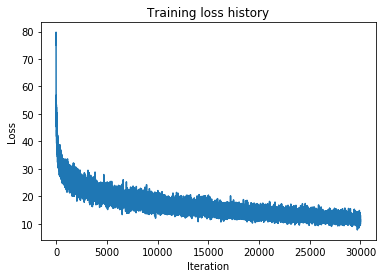

15000 512 0.005 0.99
Average BLEU score for train: 0.246890
Average BLEU score for val: 0.222316
(Iteration 1 / 30000) loss: 79.055581
(Iteration 101 / 30000) loss: 33.891651
(Iteration 201 / 30000) loss: 37.923761
(Iteration 301 / 30000) loss: 36.160047
(Iteration 401 / 30000) loss: 34.351422
(Iteration 501 / 30000) loss: 31.656031
(Iteration 601 / 30000) loss: 31.431338
(Iteration 701 / 30000) loss: 27.249596
(Iteration 801 / 30000) loss: 32.567100
(Iteration 901 / 30000) loss: 30.794900
(Iteration 1001 / 30000) loss: 22.631667
(Iteration 1101 / 30000) loss: 34.088098
(Iteration 1201 / 30000) loss: 31.497971
(Iteration 1301 / 30000) loss: 23.078250
(Iteration 1401 / 30000) loss: 24.593674
(Iteration 1501 / 30000) loss: 29.650861
(Iteration 1601 / 30000) loss: 25.100660
(Iteration 1701 / 30000) loss: 28.839429
(Iteration 1801 / 30000) loss: 25.898505
(Iteration 1901 / 30000) loss: 23.407890
(Iteration 2001 / 30000) loss: 21.795314
(Iteration 2101 / 30000) loss: 23.184764
(Iteration 22

(Iteration 19801 / 30000) loss: 6.629780
(Iteration 19901 / 30000) loss: 5.799660
(Iteration 20001 / 30000) loss: 6.309926
(Iteration 20101 / 30000) loss: 7.214303
(Iteration 20201 / 30000) loss: 6.021276
(Iteration 20301 / 30000) loss: 6.276766
(Iteration 20401 / 30000) loss: 5.593676
(Iteration 20501 / 30000) loss: 5.387503
(Iteration 20601 / 30000) loss: 5.272531
(Iteration 20701 / 30000) loss: 6.012887
(Iteration 20801 / 30000) loss: 6.536441
(Iteration 20901 / 30000) loss: 6.598893
(Iteration 21001 / 30000) loss: 5.663305
(Iteration 21101 / 30000) loss: 6.355232
(Iteration 21201 / 30000) loss: 5.757079
(Iteration 21301 / 30000) loss: 5.706352
(Iteration 21401 / 30000) loss: 4.933276
(Iteration 21501 / 30000) loss: 6.692640
(Iteration 21601 / 30000) loss: 6.126826
(Iteration 21701 / 30000) loss: 5.456651
(Iteration 21801 / 30000) loss: 5.022739
(Iteration 21901 / 30000) loss: 5.571869
(Iteration 22001 / 30000) loss: 6.285296
(Iteration 22101 / 30000) loss: 5.525332
(Iteration 22201

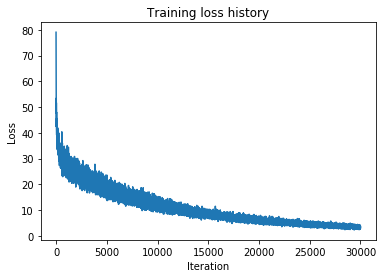

15000 512 0.005 0.95
Average BLEU score for train: 0.522695
Average BLEU score for val: 0.233590
(Iteration 1 / 30000) loss: 79.444365
(Iteration 101 / 30000) loss: 52.462285
(Iteration 201 / 30000) loss: 44.144357
(Iteration 301 / 30000) loss: 39.215978
(Iteration 401 / 30000) loss: 39.330986
(Iteration 501 / 30000) loss: 34.113945
(Iteration 601 / 30000) loss: 30.522126
(Iteration 701 / 30000) loss: 32.937612
(Iteration 801 / 30000) loss: 37.072698
(Iteration 901 / 30000) loss: 29.013633
(Iteration 1001 / 30000) loss: 26.628049
(Iteration 1101 / 30000) loss: 30.393186
(Iteration 1201 / 30000) loss: 26.967509
(Iteration 1301 / 30000) loss: 29.432553
(Iteration 1401 / 30000) loss: 28.886278
(Iteration 1501 / 30000) loss: 24.974780
(Iteration 1601 / 30000) loss: 26.924132
(Iteration 1701 / 30000) loss: 25.258426
(Iteration 1801 / 30000) loss: 26.101641
(Iteration 1901 / 30000) loss: 29.308663
(Iteration 2001 / 30000) loss: 26.151261
(Iteration 2101 / 30000) loss: 24.469421
(Iteration 22

(Iteration 19901 / 30000) loss: 1.634145
(Iteration 20001 / 30000) loss: 1.578421
(Iteration 20101 / 30000) loss: 2.243526
(Iteration 20201 / 30000) loss: 1.847052
(Iteration 20301 / 30000) loss: 1.659577
(Iteration 20401 / 30000) loss: 1.327779
(Iteration 20501 / 30000) loss: 1.329430
(Iteration 20601 / 30000) loss: 1.772988
(Iteration 20701 / 30000) loss: 1.315480
(Iteration 20801 / 30000) loss: 1.525595
(Iteration 20901 / 30000) loss: 1.573224
(Iteration 21001 / 30000) loss: 1.870197
(Iteration 21101 / 30000) loss: 1.408105
(Iteration 21201 / 30000) loss: 1.627810
(Iteration 21301 / 30000) loss: 1.198705
(Iteration 21401 / 30000) loss: 1.752437
(Iteration 21501 / 30000) loss: 1.611385
(Iteration 21601 / 30000) loss: 1.717803
(Iteration 21701 / 30000) loss: 1.789447
(Iteration 21801 / 30000) loss: 1.140374
(Iteration 21901 / 30000) loss: 1.271466
(Iteration 22001 / 30000) loss: 1.679003
(Iteration 22101 / 30000) loss: 1.389312
(Iteration 22201 / 30000) loss: 1.613953
(Iteration 22301

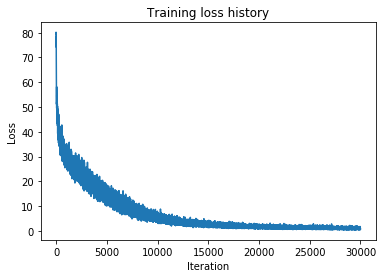

15000 768 0.0005 0.995
Average BLEU score for train: 0.915445
Average BLEU score for val: 0.252325
(Iteration 1 / 30000) loss: 79.365750
(Iteration 101 / 30000) loss: 50.444216
(Iteration 201 / 30000) loss: 42.742792
(Iteration 301 / 30000) loss: 38.023657
(Iteration 401 / 30000) loss: 35.587833
(Iteration 501 / 30000) loss: 33.940820
(Iteration 601 / 30000) loss: 34.552796
(Iteration 701 / 30000) loss: 29.526219
(Iteration 801 / 30000) loss: 28.630887
(Iteration 901 / 30000) loss: 31.292481
(Iteration 1001 / 30000) loss: 29.085761
(Iteration 1101 / 30000) loss: 28.968206
(Iteration 1201 / 30000) loss: 29.322272
(Iteration 1301 / 30000) loss: 29.569090
(Iteration 1401 / 30000) loss: 27.356537
(Iteration 1501 / 30000) loss: 26.652221
(Iteration 1601 / 30000) loss: 27.785274
(Iteration 1701 / 30000) loss: 25.565211
(Iteration 1801 / 30000) loss: 23.740374
(Iteration 1901 / 30000) loss: 25.582057
(Iteration 2001 / 30000) loss: 25.433827
(Iteration 2101 / 30000) loss: 25.382805
(Iteration 

(Iteration 19901 / 30000) loss: 1.260627
(Iteration 20001 / 30000) loss: 1.068484
(Iteration 20101 / 30000) loss: 1.180990
(Iteration 20201 / 30000) loss: 1.617741
(Iteration 20301 / 30000) loss: 1.155193
(Iteration 20401 / 30000) loss: 1.312726
(Iteration 20501 / 30000) loss: 1.154209
(Iteration 20601 / 30000) loss: 1.416783
(Iteration 20701 / 30000) loss: 0.819411
(Iteration 20801 / 30000) loss: 1.249474
(Iteration 20901 / 30000) loss: 0.969851
(Iteration 21001 / 30000) loss: 0.928523
(Iteration 21101 / 30000) loss: 1.350687
(Iteration 21201 / 30000) loss: 0.980709
(Iteration 21301 / 30000) loss: 0.829727
(Iteration 21401 / 30000) loss: 1.023030
(Iteration 21501 / 30000) loss: 1.160974
(Iteration 21601 / 30000) loss: 1.537336
(Iteration 21701 / 30000) loss: 1.590578
(Iteration 21801 / 30000) loss: 0.906955
(Iteration 21901 / 30000) loss: 1.145471
(Iteration 22001 / 30000) loss: 0.940724
(Iteration 22101 / 30000) loss: 1.172085
(Iteration 22201 / 30000) loss: 1.076626
(Iteration 22301

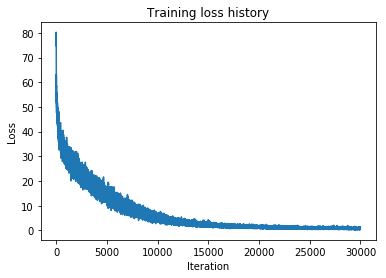

15000 768 0.0005 0.99
Average BLEU score for train: 0.936617
Average BLEU score for val: 0.258654
(Iteration 1 / 30000) loss: 76.570985
(Iteration 101 / 30000) loss: 51.305707
(Iteration 201 / 30000) loss: 46.462526
(Iteration 301 / 30000) loss: 38.816834
(Iteration 401 / 30000) loss: 35.162452
(Iteration 501 / 30000) loss: 30.937317
(Iteration 601 / 30000) loss: 38.670922
(Iteration 701 / 30000) loss: 34.050751
(Iteration 801 / 30000) loss: 30.431484
(Iteration 901 / 30000) loss: 31.873582
(Iteration 1001 / 30000) loss: 29.231498
(Iteration 1101 / 30000) loss: 29.286416
(Iteration 1201 / 30000) loss: 30.800757
(Iteration 1301 / 30000) loss: 28.345661
(Iteration 1401 / 30000) loss: 24.527799
(Iteration 1501 / 30000) loss: 31.091206
(Iteration 1601 / 30000) loss: 24.890287
(Iteration 1701 / 30000) loss: 25.838086
(Iteration 1801 / 30000) loss: 26.915210
(Iteration 1901 / 30000) loss: 24.716130
(Iteration 2001 / 30000) loss: 26.234356
(Iteration 2101 / 30000) loss: 21.913145
(Iteration 2

(Iteration 19901 / 30000) loss: 0.676257
(Iteration 20001 / 30000) loss: 0.628157
(Iteration 20101 / 30000) loss: 0.571677
(Iteration 20201 / 30000) loss: 0.568850
(Iteration 20301 / 30000) loss: 0.389706
(Iteration 20401 / 30000) loss: 0.409828
(Iteration 20501 / 30000) loss: 0.476389
(Iteration 20601 / 30000) loss: 0.622412
(Iteration 20701 / 30000) loss: 0.411809
(Iteration 20801 / 30000) loss: 0.743909
(Iteration 20901 / 30000) loss: 0.525856
(Iteration 21001 / 30000) loss: 0.353198
(Iteration 21101 / 30000) loss: 0.469206
(Iteration 21201 / 30000) loss: 0.427431
(Iteration 21301 / 30000) loss: 0.457332
(Iteration 21401 / 30000) loss: 0.574008
(Iteration 21501 / 30000) loss: 0.309143
(Iteration 21601 / 30000) loss: 0.464364
(Iteration 21701 / 30000) loss: 0.477340
(Iteration 21801 / 30000) loss: 0.474017
(Iteration 21901 / 30000) loss: 0.457014
(Iteration 22001 / 30000) loss: 0.408058
(Iteration 22101 / 30000) loss: 0.416534
(Iteration 22201 / 30000) loss: 0.428244
(Iteration 22301

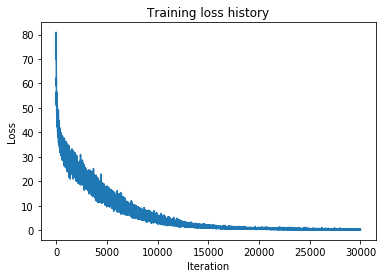

15000 768 0.0005 0.95
Average BLEU score for train: 0.954279
Average BLEU score for val: 0.258714
(Iteration 1 / 30000) loss: 76.756563
(Iteration 101 / 30000) loss: 47.390662
(Iteration 201 / 30000) loss: 36.802636
(Iteration 301 / 30000) loss: 39.395452
(Iteration 401 / 30000) loss: 32.977589
(Iteration 501 / 30000) loss: 34.042301
(Iteration 601 / 30000) loss: 31.505838
(Iteration 701 / 30000) loss: 30.918796
(Iteration 801 / 30000) loss: 31.467046
(Iteration 901 / 30000) loss: 31.863805
(Iteration 1001 / 30000) loss: 25.726847
(Iteration 1101 / 30000) loss: 25.672691
(Iteration 1201 / 30000) loss: 25.976537
(Iteration 1301 / 30000) loss: 26.991714
(Iteration 1401 / 30000) loss: 22.901490
(Iteration 1501 / 30000) loss: 24.975032
(Iteration 1601 / 30000) loss: 26.282565
(Iteration 1701 / 30000) loss: 27.936366
(Iteration 1801 / 30000) loss: 24.849809
(Iteration 1901 / 30000) loss: 21.797288
(Iteration 2001 / 30000) loss: 23.248561
(Iteration 2101 / 30000) loss: 23.854674
(Iteration 2

(Iteration 19901 / 30000) loss: 3.396624
(Iteration 20001 / 30000) loss: 2.846862
(Iteration 20101 / 30000) loss: 2.281841
(Iteration 20201 / 30000) loss: 2.773044
(Iteration 20301 / 30000) loss: 3.405433
(Iteration 20401 / 30000) loss: 2.672534
(Iteration 20501 / 30000) loss: 3.293143
(Iteration 20601 / 30000) loss: 3.796449
(Iteration 20701 / 30000) loss: 3.127462
(Iteration 20801 / 30000) loss: 3.835181
(Iteration 20901 / 30000) loss: 3.242269
(Iteration 21001 / 30000) loss: 3.532228
(Iteration 21101 / 30000) loss: 3.261681
(Iteration 21201 / 30000) loss: 3.360820
(Iteration 21301 / 30000) loss: 3.766128
(Iteration 21401 / 30000) loss: 3.675201
(Iteration 21501 / 30000) loss: 3.265196
(Iteration 21601 / 30000) loss: 3.034168
(Iteration 21701 / 30000) loss: 2.807060
(Iteration 21801 / 30000) loss: 3.536244
(Iteration 21901 / 30000) loss: 3.187196
(Iteration 22001 / 30000) loss: 2.328254
(Iteration 22101 / 30000) loss: 3.478904
(Iteration 22201 / 30000) loss: 2.494951
(Iteration 22301

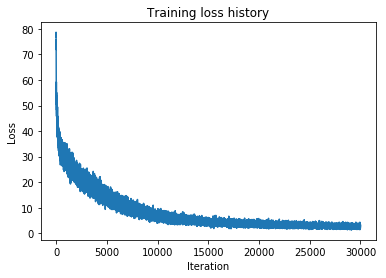

15000 768 0.001 0.995
Average BLEU score for train: 0.679463
Average BLEU score for val: 0.243991
(Iteration 1 / 30000) loss: 83.693884
(Iteration 101 / 30000) loss: 47.758428
(Iteration 201 / 30000) loss: 40.410380
(Iteration 301 / 30000) loss: 37.557943
(Iteration 401 / 30000) loss: 32.503503
(Iteration 501 / 30000) loss: 35.839166
(Iteration 601 / 30000) loss: 31.514616
(Iteration 701 / 30000) loss: 28.185498
(Iteration 801 / 30000) loss: 29.708034
(Iteration 901 / 30000) loss: 26.425871
(Iteration 1001 / 30000) loss: 26.531058
(Iteration 1101 / 30000) loss: 27.889445
(Iteration 1201 / 30000) loss: 27.739880
(Iteration 1301 / 30000) loss: 25.379221
(Iteration 1401 / 30000) loss: 27.260597
(Iteration 1501 / 30000) loss: 21.411521
(Iteration 1601 / 30000) loss: 26.178567
(Iteration 1701 / 30000) loss: 26.746820
(Iteration 1801 / 30000) loss: 23.355577
(Iteration 1901 / 30000) loss: 24.032334
(Iteration 2001 / 30000) loss: 24.238946
(Iteration 2101 / 30000) loss: 23.275601
(Iteration 2

(Iteration 19901 / 30000) loss: 2.393077
(Iteration 20001 / 30000) loss: 2.818070
(Iteration 20101 / 30000) loss: 1.849543
(Iteration 20201 / 30000) loss: 2.223335
(Iteration 20301 / 30000) loss: 3.216105
(Iteration 20401 / 30000) loss: 2.012846
(Iteration 20501 / 30000) loss: 1.906411
(Iteration 20601 / 30000) loss: 1.852273
(Iteration 20701 / 30000) loss: 2.297514
(Iteration 20801 / 30000) loss: 2.630130
(Iteration 20901 / 30000) loss: 1.877314
(Iteration 21001 / 30000) loss: 2.801091
(Iteration 21101 / 30000) loss: 1.848395
(Iteration 21201 / 30000) loss: 2.630262
(Iteration 21301 / 30000) loss: 1.864372
(Iteration 21401 / 30000) loss: 2.355768
(Iteration 21501 / 30000) loss: 1.665599
(Iteration 21601 / 30000) loss: 2.030338
(Iteration 21701 / 30000) loss: 2.128219
(Iteration 21801 / 30000) loss: 1.817947
(Iteration 21901 / 30000) loss: 3.231187
(Iteration 22001 / 30000) loss: 1.940514
(Iteration 22101 / 30000) loss: 2.035755
(Iteration 22201 / 30000) loss: 2.028207
(Iteration 22301

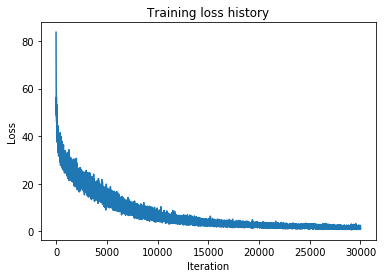

15000 768 0.001 0.99
Average BLEU score for train: 0.825061
Average BLEU score for val: 0.246083
(Iteration 1 / 30000) loss: 75.405228
(Iteration 101 / 30000) loss: 45.537742
(Iteration 201 / 30000) loss: 38.513272
(Iteration 301 / 30000) loss: 35.537428
(Iteration 401 / 30000) loss: 36.993221
(Iteration 501 / 30000) loss: 34.611137
(Iteration 601 / 30000) loss: 31.656870
(Iteration 701 / 30000) loss: 30.697381
(Iteration 801 / 30000) loss: 30.730171
(Iteration 901 / 30000) loss: 31.646775
(Iteration 1001 / 30000) loss: 25.685236
(Iteration 1101 / 30000) loss: 24.249184
(Iteration 1201 / 30000) loss: 27.130612
(Iteration 1301 / 30000) loss: 26.911604
(Iteration 1401 / 30000) loss: 22.861472
(Iteration 1501 / 30000) loss: 27.019122
(Iteration 1601 / 30000) loss: 25.937476
(Iteration 1701 / 30000) loss: 25.034792
(Iteration 1801 / 30000) loss: 23.370930
(Iteration 1901 / 30000) loss: 23.296651
(Iteration 2001 / 30000) loss: 27.511607
(Iteration 2101 / 30000) loss: 24.593798
(Iteration 22

(Iteration 19901 / 30000) loss: 0.224642
(Iteration 20001 / 30000) loss: 0.404870
(Iteration 20101 / 30000) loss: 0.426727
(Iteration 20201 / 30000) loss: 0.867660
(Iteration 20301 / 30000) loss: 0.169050
(Iteration 20401 / 30000) loss: 0.256682
(Iteration 20501 / 30000) loss: 0.291286
(Iteration 20601 / 30000) loss: 0.178503
(Iteration 20701 / 30000) loss: 0.335004
(Iteration 20801 / 30000) loss: 0.129263
(Iteration 20901 / 30000) loss: 0.206286
(Iteration 21001 / 30000) loss: 0.450937
(Iteration 21101 / 30000) loss: 0.513058
(Iteration 21201 / 30000) loss: 0.120752
(Iteration 21301 / 30000) loss: 0.183063
(Iteration 21401 / 30000) loss: 0.280656
(Iteration 21501 / 30000) loss: 0.218935
(Iteration 21601 / 30000) loss: 0.335756
(Iteration 21701 / 30000) loss: 0.250011
(Iteration 21801 / 30000) loss: 0.207228
(Iteration 21901 / 30000) loss: 0.213701
(Iteration 22001 / 30000) loss: 0.115228
(Iteration 22101 / 30000) loss: 0.154899
(Iteration 22201 / 30000) loss: 0.295594
(Iteration 22301

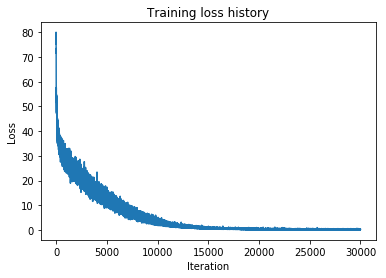

15000 768 0.001 0.95
Average BLEU score for train: 0.956904
Average BLEU score for val: 0.266106
(Iteration 1 / 30000) loss: 77.746006
(Iteration 101 / 30000) loss: 34.927948
(Iteration 201 / 30000) loss: 34.859302
(Iteration 301 / 30000) loss: 33.753279
(Iteration 401 / 30000) loss: 32.889557
(Iteration 501 / 30000) loss: 31.893441
(Iteration 601 / 30000) loss: 30.833647
(Iteration 701 / 30000) loss: 29.621478
(Iteration 801 / 30000) loss: 28.492062
(Iteration 901 / 30000) loss: 28.748335
(Iteration 1001 / 30000) loss: 25.881010
(Iteration 1101 / 30000) loss: 26.238920
(Iteration 1201 / 30000) loss: 23.207512
(Iteration 1301 / 30000) loss: 23.110036
(Iteration 1401 / 30000) loss: 25.054899
(Iteration 1501 / 30000) loss: 25.935024
(Iteration 1601 / 30000) loss: 25.097177
(Iteration 1701 / 30000) loss: 25.219632
(Iteration 1801 / 30000) loss: 24.383210
(Iteration 1901 / 30000) loss: 22.994585
(Iteration 2001 / 30000) loss: 23.023987
(Iteration 2101 / 30000) loss: 25.097261
(Iteration 22

(Iteration 19601 / 30000) loss: 14.728085
(Iteration 19701 / 30000) loss: 15.509976
(Iteration 19801 / 30000) loss: 16.119634
(Iteration 19901 / 30000) loss: 14.330115
(Iteration 20001 / 30000) loss: 14.792490
(Iteration 20101 / 30000) loss: 16.980201
(Iteration 20201 / 30000) loss: 13.768297
(Iteration 20301 / 30000) loss: 14.884382
(Iteration 20401 / 30000) loss: 13.574001
(Iteration 20501 / 30000) loss: 13.968764
(Iteration 20601 / 30000) loss: 13.481075
(Iteration 20701 / 30000) loss: 14.577379
(Iteration 20801 / 30000) loss: 14.076945
(Iteration 20901 / 30000) loss: 16.824314
(Iteration 21001 / 30000) loss: 16.114449
(Iteration 21101 / 30000) loss: 13.937127
(Iteration 21201 / 30000) loss: 16.226433
(Iteration 21301 / 30000) loss: 13.343051
(Iteration 21401 / 30000) loss: 14.507586
(Iteration 21501 / 30000) loss: 17.205086
(Iteration 21601 / 30000) loss: 14.558112
(Iteration 21701 / 30000) loss: 15.518388
(Iteration 21801 / 30000) loss: 15.157033
(Iteration 21901 / 30000) loss: 13

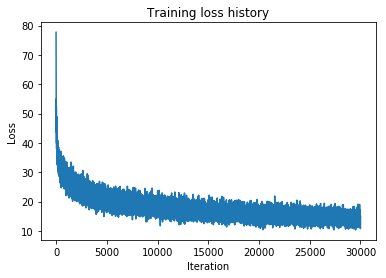

15000 768 0.005 0.995
Average BLEU score for train: 0.251170
Average BLEU score for val: 0.218043
(Iteration 1 / 30000) loss: 79.750126
(Iteration 101 / 30000) loss: 40.737415
(Iteration 201 / 30000) loss: 30.932484
(Iteration 301 / 30000) loss: 32.348200
(Iteration 401 / 30000) loss: 31.052951
(Iteration 501 / 30000) loss: 28.129482
(Iteration 601 / 30000) loss: 28.675444
(Iteration 701 / 30000) loss: 23.309813
(Iteration 801 / 30000) loss: 26.960237
(Iteration 901 / 30000) loss: 30.125693
(Iteration 1001 / 30000) loss: 28.577863
(Iteration 1101 / 30000) loss: 26.372071
(Iteration 1201 / 30000) loss: 28.032011
(Iteration 1301 / 30000) loss: 28.816566
(Iteration 1401 / 30000) loss: 25.107639
(Iteration 1501 / 30000) loss: 26.652539
(Iteration 1601 / 30000) loss: 23.874616
(Iteration 1701 / 30000) loss: 25.333938
(Iteration 1801 / 30000) loss: 25.415231
(Iteration 1901 / 30000) loss: 24.048376
(Iteration 2001 / 30000) loss: 23.677746
(Iteration 2101 / 30000) loss: 25.322621
(Iteration 2

(Iteration 19601 / 30000) loss: 16.103201
(Iteration 19701 / 30000) loss: 15.304721
(Iteration 19801 / 30000) loss: 13.538631
(Iteration 19901 / 30000) loss: 11.947523
(Iteration 20001 / 30000) loss: 14.096551
(Iteration 20101 / 30000) loss: 16.439922
(Iteration 20201 / 30000) loss: 13.235213
(Iteration 20301 / 30000) loss: 16.931376
(Iteration 20401 / 30000) loss: 13.750989
(Iteration 20501 / 30000) loss: 12.532274
(Iteration 20601 / 30000) loss: 15.442908
(Iteration 20701 / 30000) loss: 12.393529
(Iteration 20801 / 30000) loss: 14.811873
(Iteration 20901 / 30000) loss: 12.927714
(Iteration 21001 / 30000) loss: 14.782769
(Iteration 21101 / 30000) loss: 13.957370
(Iteration 21201 / 30000) loss: 13.862320
(Iteration 21301 / 30000) loss: 10.453889
(Iteration 21401 / 30000) loss: 13.753476
(Iteration 21501 / 30000) loss: 11.564862
(Iteration 21601 / 30000) loss: 16.143067
(Iteration 21701 / 30000) loss: 13.992921
(Iteration 21801 / 30000) loss: 13.731670
(Iteration 21901 / 30000) loss: 13

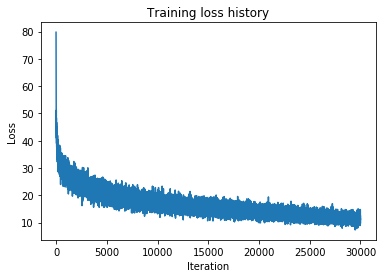

15000 768 0.005 0.99
Average BLEU score for train: 0.263384
Average BLEU score for val: 0.219139
(Iteration 1 / 30000) loss: 76.411207
(Iteration 101 / 30000) loss: 42.096717
(Iteration 201 / 30000) loss: 34.910932
(Iteration 301 / 30000) loss: 34.509232
(Iteration 401 / 30000) loss: 31.071999
(Iteration 501 / 30000) loss: 31.491932
(Iteration 601 / 30000) loss: 30.669247
(Iteration 701 / 30000) loss: 28.586719
(Iteration 801 / 30000) loss: 31.204754
(Iteration 901 / 30000) loss: 29.447385
(Iteration 1001 / 30000) loss: 27.531891
(Iteration 1101 / 30000) loss: 23.794954
(Iteration 1201 / 30000) loss: 24.107728
(Iteration 1301 / 30000) loss: 23.695075
(Iteration 1401 / 30000) loss: 24.706968
(Iteration 1501 / 30000) loss: 24.249240
(Iteration 1601 / 30000) loss: 29.470985
(Iteration 1701 / 30000) loss: 25.393861
(Iteration 1801 / 30000) loss: 22.622625
(Iteration 1901 / 30000) loss: 23.193676
(Iteration 2001 / 30000) loss: 23.449946
(Iteration 2101 / 30000) loss: 24.313050
(Iteration 22

(Iteration 19801 / 30000) loss: 4.211147
(Iteration 19901 / 30000) loss: 4.820519
(Iteration 20001 / 30000) loss: 4.523667
(Iteration 20101 / 30000) loss: 4.481612
(Iteration 20201 / 30000) loss: 5.044393
(Iteration 20301 / 30000) loss: 4.851308
(Iteration 20401 / 30000) loss: 4.097127
(Iteration 20501 / 30000) loss: 4.559157
(Iteration 20601 / 30000) loss: 4.140365
(Iteration 20701 / 30000) loss: 4.358935
(Iteration 20801 / 30000) loss: 4.547757
(Iteration 20901 / 30000) loss: 3.442582
(Iteration 21001 / 30000) loss: 5.006221
(Iteration 21101 / 30000) loss: 5.346825
(Iteration 21201 / 30000) loss: 4.158355
(Iteration 21301 / 30000) loss: 4.392168
(Iteration 21401 / 30000) loss: 4.134167
(Iteration 21501 / 30000) loss: 3.785724
(Iteration 21601 / 30000) loss: 3.892374
(Iteration 21701 / 30000) loss: 4.314516
(Iteration 21801 / 30000) loss: 3.832105
(Iteration 21901 / 30000) loss: 4.497667
(Iteration 22001 / 30000) loss: 4.072589
(Iteration 22101 / 30000) loss: 3.346993
(Iteration 22201

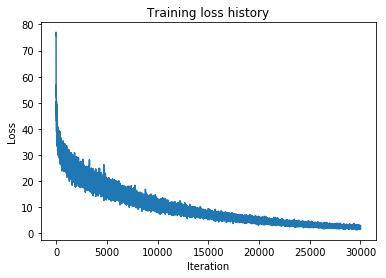

15000 768 0.005 0.95
Average BLEU score for train: 0.639005
Average BLEU score for val: 0.226258


In [12]:
for max_train in [10000, 15000]:
    for hidden_dim in [512, 768]:
        for learning_rate in [5e-4, 1e-3, 5e-3]:
            for lr_decay in [0.995, 0.99, 0.95]:
                data = load_coco_data(max_train=max_train)

                lstm_model = CaptioningRNN(
                          cell_type='lstm',
                          word_to_idx=data['word_to_idx'],
                          input_dim=data['train_features'].shape[1],
                          hidden_dim=hidden_dim,
                          wordvec_dim=256,
                          dtype=np.float32,
                        )

                lstm_solver = CaptioningSolver(lstm_model, data,
                           update_rule='adam',
                           num_epochs=50,
                           batch_size=25,
                           optim_config={
                             'learning_rate': learning_rate,
                           },
                           lr_decay=lr_decay,
                           verbose=True, print_every=100,
                         )

                lstm_solver.train()

                # Plot the training losses
                plt.plot(lstm_solver.loss_history)
                plt.xlabel('Iteration')
                plt.ylabel('Loss')
                plt.title('Training loss history')
                plt.show()
                
                print(max_train, hidden_dim, learning_rate, lr_decay)
                evaluate_model(lstm_model, data)